<a href="https://colab.research.google.com/github/tsenga2/keio-quant-macro/blob/main/gourio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
import time

# Start timing
tic = time.time()

# Function: gridlookup
def gridlookup(n, grid, val):
    # Find the index of the closest value in the grid
    idx = (np.abs(grid - val)).argmin()

    # If the value is greater than the grid value, the weight is the difference
    if val > grid[idx]:
    #if val > grid[idx]:
        weight = val - grid[idx]
    # Otherwise, the weight is 1 minus the difference
    else:
        weight = 1 - (grid[idx] - val)

    return idx, weight

In [75]:
# Parameters
alpha = 0.5
delta = 0.167
r = 0.04
rho = 0.55
mu = 0
sigma = 0.35

# Setup a grid for capital
nk = 200
kmin = 0.001
kmax = 20
kgrid = np.linspace(kmin, kmax, nk)
# Setup a grid for productivity
nz = 5

# Discrete-state approximation to AR1
# log(Z') = rho*log(Z) + (1-rho)*mu + sigma*epsilon
z = [-0.942927835640568, -0.471463917820284, 0, 0.471463917820284, 0.942927835640568]
Z = np.exp(z)
Pie = np.array([[0.295006943581673, 0.495512193838656, 0.193910257281772, 0.015339978264313, 0.000230627033585],
              [0.100327482548650, 0.426521772368601, 0.394527290061208, 0.075746025821068, 0.002877429200473],
              [0.021662684832732, 0.228645617148758, 0.499383396037020, 0.228645617148758, 0.021662684832732],
              [0.002877429200473, 0.075746025821068, 0.394527290061208, 0.426521772368602, 0.100327482548650],
              [0.000230627033585, 0.015339978264313, 0.193910257281772, 0.495512193838656, 0.295006943581673]])

In [76]:
# Decision (VFI)
v = np.zeros((nz, nk))
Tv = np.zeros((nz, nk))
g_vfi = np.zeros((nz, nk))

tol = 1e-6

for it in range(1000):
    ev = Pie @ v

    for i in range(nz):
        Zval = Z[i]

        for j in range(nk):
            kval = kgrid[j]

            RHS = np.empty(nk)
            for jj in range(nk):
                kfval = kgrid[jj]
                RHS[jj] = Zval * kval**alpha - kfval + (1 - delta) * kval + (1 / (1 + r)) * ev[i, jj]

            Tv[i, j] = np.max(RHS)
            g_vfi[i, j] = kgrid[np.argmax(RHS)]

    norm = np.max(np.abs(Tv - v))

    # Print iteration information
    if it < 20 or it % 10 == 0:
      print(f'iteration {it:4} with norm {norm:9.8f}')

    if norm < tol:
        break

    v = Tv
    Tv = np.zeros((nz, nk))

iteration    0 with norm 28.14115364
iteration    1 with norm 3.57671539
iteration    2 with norm 2.33524523
iteration    3 with norm 1.80607091
iteration    4 with norm 1.53682570
iteration    5 with norm 1.38064772
iteration    6 with norm 1.27876087
iteration    7 with norm 1.20463541
iteration    8 with norm 1.14544068
iteration    9 with norm 1.09472357
iteration   10 with norm 1.04916130
iteration   11 with norm 1.00701254
iteration   12 with norm 0.96734747
iteration   13 with norm 0.92965625
iteration   14 with norm 0.89364773
iteration   15 with norm 0.85914535
iteration   16 with norm 0.82603300
iteration   17 with norm 0.79422698
iteration   18 with norm 0.76366132
iteration   19 with norm 0.73428012
iteration   20 with norm 0.70603358
iteration   30 with norm 0.47696702
iteration   40 with norm 0.32222182
iteration   50 with norm 0.21768152
iteration   60 with norm 0.14705783
iteration   70 with norm 0.09934700
iteration   80 with norm 0.06711528
iteration   90 with norm 0.

In [77]:
# Distribution
mu = np.zeros((nz, nk))
mu[0, 0] = 1
munext = np.zeros((nz, nk))

for it in range(200):
    for i in range(nz):
        for j in range(nk):
            muval = mu[i, j]

            if muval > 0:
                kloc, kweight = gridlookup(nk, kgrid, g_vfi[i, j])
                for ii in range(nz):
                    munext[ii, kloc] += Pie[i, ii] * kweight* muval
                    munext[ii, kloc + 1] += Pie[i, ii] * (1 - kweight) * muval

    error = np.max(np.abs(munext - mu))

    print(f'iteration {it:4} with error {error:9.8f}')

    if np.linalg.norm(munext - mu, np.inf) < tol:
        break

    mu = munext
    munext = np.zeros((nz, nk))

iteration    0 with error 1.00000000
iteration    1 with error 0.34933266
iteration    2 with error 0.08076029
iteration    3 with error 0.03104798
iteration    4 with error 0.01732823
iteration    5 with error 0.00933748
iteration    6 with error 0.00502375
iteration    7 with error 0.00270838
iteration    8 with error 0.00146238
iteration    9 with error 0.00079029
iteration   10 with error 0.00042728
iteration   11 with error 0.00023106
iteration   12 with error 0.00012497
iteration   13 with error 0.00006759
iteration   14 with error 0.00003656
iteration   15 with error 0.00001977
iteration   16 with error 0.00001070
iteration   17 with error 0.00000579
iteration   18 with error 0.00000313
iteration   19 with error 0.00000169
iteration   20 with error 0.00000092
iteration   21 with error 0.00000050
iteration   22 with error 0.00000027


In [78]:
# Aggregation
yagg = 0
kagg = 0

for i in range(nz):
    for j in range(nk):
        muval = mu[i, j]
        yagg += muval * Z[i] * kgrid[j]**alpha
        kagg += muval * kgrid[j]

tfp = np.exp(np.log(yagg) - alpha * np.log(kagg))

print(f'log(Y) {np.log(yagg):.4f} log(K) {np.log(kagg):.4f} log(TFP) {np.log(tfp):.4f}')

log(Y) 1.1301 log(K) 2.0127 log(TFP) 0.1238


In [79]:
# analytical solution feasible
mu = 0
logy = mu + 0.5*(sigma**2/(1-rho)) + alpha/(1-alpha)*(mu+0.5*sigma**2) - alpha/(1-alpha)*np.log((r+delta)/alpha) + 0.5*alpha**2*(rho/(1-alpha))**2*(sigma**2/(1-rho**2)) + (rho**2/(1-alpha))*(sigma**2/(1-rho**2))
logk = 1/(1-alpha)*(mu+0.5*sigma**2) - 1/(1-alpha)*np.log((r+delta)/alpha) + 0.5*(rho/(1-alpha))**2*(sigma**2/(1-rho**2))
logtfp = mu + 0.5*(sigma**2/(1-rho)) + (rho**2*alpha)/(1-alpha)*((sigma**2)/(1-rho**2))*0.5

print(f'log(Y) {logy:.4f} log(K) {logk:.4f} log(TFP) {logtfp:.4f}')

log(Y) 1.2121 log(K) 1.9925 log(TFP) 0.1627


Elapsed time: 137.50311517715454 seconds


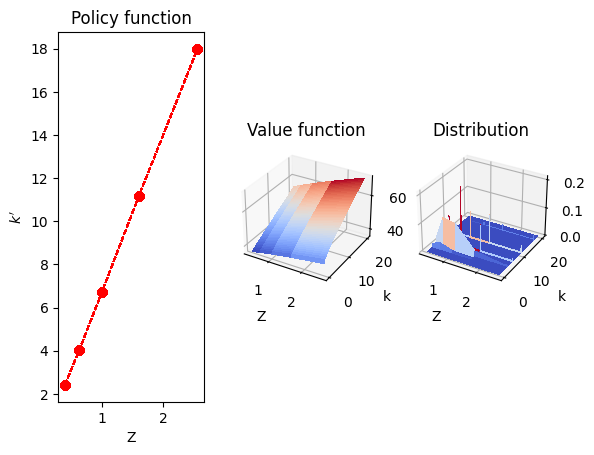

In [80]:
# Plot figures
fig = plt.figure('Gourio2008')

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(Z, g_vfi, '--or', linewidth=1)
ax1.set_xlabel('Z')
ax1.set_ylabel('$k\'$')
ax1.set_title('Policy function')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
X, Y = np.meshgrid(Z, kgrid)
ax2.plot_surface(X, Y, v.T, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_xlabel('Z')
ax2.set_ylabel('k')
ax2.set_title('Value function')

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
X, Y = np.meshgrid(Z, kgrid)
ax3.plot_surface(X, Y, munext.T, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax3.set_xlabel('Z')
ax3.set_ylabel('k')
ax3.set_title('Distribution')

# Stop timing
toc = time.time()

# Print the elapsed time
print("Elapsed time: {} seconds".format(toc - tic))